# Preprocessing of data

### Import libraries and preproc

In [139]:
import sys
import numpy as np
from tqdm import tqdm
import nibabel
#!{sys.executable} -m pip install nilearn #install relevant neuroimaging package
#!{sys.executable} -m pip install opencv-python #install video package
from preprocessing import load_and_mask_miyawaki_data
from plots import plt_fmri_stim
import matplotlib.pyplot as plt

In [142]:
fmri_data, stimuli, fmri_figures_data, stimuli_figures, masker = load_and_mask_miyawaki_data()

Preprocessing data...

The shape of the masked data is (20, 145, 5438)
Preprocessed fMRI data: 2860 samples x 5438 voxels
Preprocessed stimuli data: 2860 samples x 100 pixels
1536 geometrical figures


 Done (23.55s).


In [143]:
stimuli[0]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [148]:
a = np.array([[-1.,-1.,-1.],[0,1,0]])
a = [[0 if k == -1 else k for k in abc] for abc in a]
a

[[0, 0, 0], [0.0, 1.0, 0.0]]

### Create data sets

In [124]:
all_fmri = np.concatenate((fmri_data, fmri_figures_data))
all_stimuli = np.concatenate((stimuli, stimuli_figures))

#erase black figs: """"""useless"""""" for our use of the data
        
stimuli2 = np.array([element for element in stimuli if np.sum(element) != -100])
fmri_data2 = np.array([fmri_data[i] for i in range(len(fmri_data)) if np.sum(stimuli[i]) != -100])

all_stimuli2 = np.array([element for element in all_stimuli if np.sum(element) != -100])
all_fmri2 = np.array([all_fmri[i] for i in range(len(all_fmri)) if np.sum(all_stimuli[i]) != -100])

stimuli_figures2 = np.concatenate((np.array([element for element in stimuli_figures if np.sum(element) != -100]),np.array([stimuli_figures[4]])))
fmri_figures_data2 = np.concatenate((np.array([fmri_figures_data[i] for i in range(len(fmri_figures_data)) if np.sum(stimuli_figures[i]) != -100]), np.array([fmri_figures_data[4]])))

In [125]:
from sklearn.model_selection import train_test_split

#random images avec les carrés noirs
train_to_test_ratio = 0.8
X_train, X_test, Y_train, Y_test =train_test_split(fmri_data, stimuli, 
                                        train_size=train_to_test_ratio, 
                                        test_size=1.0-train_to_test_ratio)

#geometric images avec les carrés noirs
train_to_test_ratio = 0.8
X_trainfig, X_testfig, Y_trainfig, Y_testfig =train_test_split(fmri_figures_data, stimuli_figures, 
                                        train_size=train_to_test_ratio, 
                                        test_size=1.0-train_to_test_ratio)

#geometric images sans les carrés noirs
train_to_test_ratio = 0.8
X_trainfig2, X_testfig2, Y_trainfig2, Y_testfig2 =train_test_split(fmri_figures_data2, stimuli_figures2, 
                                        train_size=train_to_test_ratio, 
                                        test_size=1.0-train_to_test_ratio)

#random images sans les carrés noirs
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(fmri_data2, stimuli2, 
                                        train_size=train_to_test_ratio, 
                                        test_size=1.0-train_to_test_ratio)

#avec tout
X_train_all, X_test_all, Y_train_all, Y_test_all =train_test_split(all_fmri, all_stimuli, 
                                        train_size=train_to_test_ratio, 
                                        test_size=1.0-train_to_test_ratio)

X_train_all2, X_test_all2, Y_train_all2, Y_test_all2 =train_test_split(all_fmri2, all_stimuli2, train_size=train_to_test_ratio, test_size=1.0-train_to_test_ratio)

### Manipulate stimuli images for multiscale analysis

In [126]:
# Create list pixel_indices of 4-uplets of incidices of pixels we want to average together for the 2*2 scale
k = [2*i for i in range(5)] #list used to generate pixel_indices
pixel_indices_22 = [[10*a+b, 10*a+(b+1), 10*(a+1)+b, 10*(a+1)+(b+1)] for a in k for b in k]

In [127]:
# Preprocessing of stimuli data for multi scale encoding

def preproc_one_stimuli(idx_pxl_toavg, stimuli, reshape = False, reshape_form = (5,5)) :
    """
    Permits to preproc 1 stimuli figure by averaging some pixels together for the 
    multiscale encoding.
    - idx_pxl_toavg : liste de multiplets d'indices de pixels que l'on souhaite moyenner
                      ensemble. Par ex, pour le 2*2 on a :
                      [[0,1,10,11], [2,3,12,13], ... ,[88,89,98,99]].
    - stimuli: the image
    - reshape : if you want your image to be reshaped in such a way that you can plot it
    - reshape_form : (5,5) for a 5 by 5 image, etc...
    """
    if reshape == False :
        return np.array([np.average([stimuli[i] for i in idx]) for idx in idx_pxl_toavg])
    
    else :
        return np.array(np.reshape([np.average([stimuli[i] for i in idx]) for idx in idx_pxl_toavg],(5,5)))
    

def preproc_multiple_stimuli(idx_pxl_toavg, stimuli_list, reshape = False, reshape_form = (5,5)) :
    """
    Same as above but to preproc a whole list of stimulis
    Sorry this looks horrible
    """
    if reshape == False :
        return np.array([[np.average([stimuli[i] for i in idx]) for idx in idx_pxl_toavg] for stimuli in stimuli_list])
    
    else :
        reshape_form_multi = (len(stimuli_list),reshape_form[0],reshape_form[1])
        return np.array(np.reshape([np.average([stimuli[i] for i in idx]) for idx in idx_pxl_toavg for stimuli in stimuli_list],reshape_form_multi))
    
def Y_train_newscale(Y_train, idx_pxl_toavg) :
    """
    Creates a new Y_train but with rescaled images 
    Changes greyscale values to classes (integers) : for this, we want to map the values of greyscale to
    integers. We notice that for 4 pixels, only possible values are [0,0.25,0.5,0.75,1]. For 2 pixels, [0,0.5,1]. Etc.
    By multiplying these grayscale values by the number of pixels we get [0,1,2,3,4] or [0,1,2], etc. Hence the multiplication.
    """
    Y_continuous = preproc_multiple_stimuli(idx_pxl_toavg, Y_train) #with values in [0,1]
    n = len(idx_pxl_toavg[0]) #number of classes is the number of pixels there is to average + 1. For instance for 4 pixels you can have [0,0.25,0.5,0.75,1]
    Y_integers = [[int(pixel_val * n) if pixel_val != -1 else 0 for pixel_val in img] for img in Y_continuous]
    return Y_integers

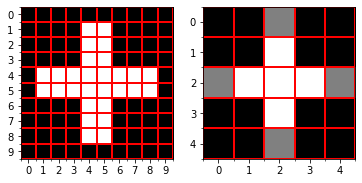

In [128]:
# Check that stimuli processing works

imag = stimuli_figures2[30]

old = np.reshape(imag,(10,10))
new = preproc_one_stimuli(pixel_indices_22, imag, reshape = True)

fig = plt.figure()
sp1 = plt.subplot(121)
sp2 = plt.subplot(122)

# to show the grid 

for ax in (sp1, sp2) :

    # Major ticks
    ax.set_xticks(np.arange(0, 10, 1))
    ax.set_yticks(np.arange(0, 10, 1))

    # Minor ticks
    ax.set_xticks(np.arange(-.5, 10, 1), minor=True)
    ax.set_yticks(np.arange(-.5, 10, 1), minor=True)
    
    ax.grid(which='minor', color='r', linestyle='-', linewidth=2)


sp1.imshow(old, cmap = plt.cm.gray, interpolation = 'nearest')
sp2.imshow(new, cmap = plt.cm.gray, interpolation = 'nearest')

It works !

# Train a log reg at the different scales

In [137]:
from sklearn import linear_model

def train_logreg_scale(X_train, Y_train, X_test, Y_test, scale) :
    """
    Trains a log reg for a certain scale 
    """
    logreg_table = []
    size = int(100/scale[0]*scale[1])
    
    train_accuracy, test_accuracy = np.zeros(size), np.zeros(size)

    # loop over regularisation strength
    for i, pixel in tqdm(enumerate(np.transpose(Y_train))):
    
        # define logistic regressor
        logreg = linear_model.LogisticRegression(penalty="l2", C=0.05, max_iter = 15000, multi_class='multinomial')
    
        # fit training data
        logreg.fit(X_train, pixel)
    
        logreg_table.append(logreg)
    
        # check accuracy
        train_accuracy[i]=logreg.score(X_train,pixel)
        test_accuracy[i]=logreg.score(X_test,np.transpose(Y_test)[i])
        
    return logreg_table, train_accuracy, test_accuracy

In [138]:
#Prediction functions for initial pixels
[logreg_table_11, train_accuracy_11, test_accuracy_11] = train_logreg_scale(X_train, Y_train, X_test, Y_test, (1,1))

100it [16:20,  9.81s/it]


In [ ]:
# New Y_train for 2*2 block averaged images
Y_train_22, Y_test_22 = Y_train_newscale(Y_train, pixel_indices_22), Y_train_newscale(Y_test, pixel_indices_22)

[logreg_table_22, train_accuracy_22, test_accuracy_22] = train_logreg_scale(X_train, Y_train_22, X_test, Y_test_22,(2,2))

In [98]:
n = 47
Y_train[n], Y_train_22[n]

(array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1.]),
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [117]:
n=48
imag = stimuli_figures2[n]

old = np.reshape(imag,(10,10))
new = preproc_one_stimuli(pixel_indices_22, imag, reshape = True)
pred = np.zeros(25)

xtest = fmri_figures_data2[n].reshape(1,-1)
ytest = new

for i,pixel in enumerate(pred) :
    y = logreg_table_22[i].predict(xtest)
    
    pred[i] = y
    
pred = np.reshape(pred,(5,5))

pred_greyscale = [x/4 for x in pred]


def predict_stim(logreg_table, X, size):
    
    pred = np.zeros(size)

    for i,pixel in enumerate(pred) :
        
        y = logreg_table_22[i].predict(xtest)
        pred[i] = y
        
    pred = np.reshape(pred,(5,5))
    

0.7437062937062937

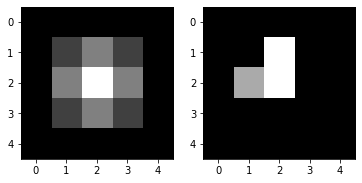

In [119]:
fig = plt.figure()
sp1 = plt.subplot(121)
sp2 = plt.subplot(122)
sp1.imshow(ytest, cmap = plt.cm.gray, interpolation = 'nearest')
sp2.imshow(pred_greyscale, cmap = plt.cm.gray, interpolation = 'nearest')
np.average(test_accuracy_22)

In [ ]:
#combine all multiscale predictions

fig = plt.figure()
sp1 = plt.subplot(121)
sp2 = plt.subplot(122)
sp1.imshow(ytest, cmap = plt.cm.gray, interpolation = 'nearest')
sp2.imshow(pred_greyscale, cmap = plt.cm.gray, interpolation = 'nearest')
sp2.imshow(pred_greyscale, cmap = plt.cm.gray, interpolation = 'nearest')
np.average(test_accuracy_22)